<a href="https://colab.research.google.com/github/jcandane/CI_Theory/blob/main/FCI56.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Goal of this notebook is to introduce a standalone FCI program in Python.

## Import Libraries, set defaults

In [ ]:
!pip install pyscf

import numpy as np
from itertools import combinations, permutations
from pyscf import fci, ao2mo, scf, gto

π = np.pi
α = 0.007297352
c = 1.0/α
np.set_printoptions(precision=4, linewidth=200, threshold=2000, suppress=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 37.5 MB 1.3 MB/s 


## Let's define a few useful python functions:

### Determinant Manipulation

In [ ]:
def givenΛgetB(ΛA, ΛB, N_mo):
  "Given Λ (i occupied orbitals for each determinant) get B (binary rep.)"

  Binary  = np.zeros((ΛA.shape[0], 2, N_mo), dtype=np.int8)
  for I in range(len(Binary)):
      Binary[I, 0, ΛA[I,:]] = 1
      Binary[I, 1, ΛB[I,:]] = 1

  return Binary

def SpinOuterProduct(A, B, stack=False):
  ΛA = np.einsum("Ii, J -> IJi", A, np.ones(B.shape[0], dtype=np.int8)).reshape( (A.shape[0]*B.shape[0], A.shape[1]) )
  ΛB = np.einsum("Ii, J -> JIi", B, np.ones(A.shape[0], dtype=np.int8)).reshape( (A.shape[0]*B.shape[0], B.shape[1]) )
  
  if stack:
    return np.array([ΛA,ΛB])
  else:
    return ΛA, ΛB

def get_fci_combos(mf):

    O_sp   = np.asarray(mf.mo_occ, dtype=np.int8)
    N_s    = np.einsum("sp -> s", O_sp)
    N      = O_sp.shape[1]

    Λ_α = np.asarray( list(combinations(  np.arange(0, N, 1, dtype=np.int8)  , N_s[0] ) ) ) 
    Λ_β = np.asarray( list(combinations(  np.arange(0, N, 1, dtype=np.int8)  , N_s[1] ) ) ) 
    ΛA, ΛB = SpinOuterProduct(Λ_α, Λ_β)
    Binary = givenΛgetB(ΛA, ΛB, N)

    return Binary

### Slater-Condon Rules

In [ ]:
def determinantsign(Binary):
    sign  = np.cumsum( Binary, axis=2)
    for I in range(len(Binary)):
        iia = np.where( Binary[I,0] == 1)[0]
        iib = np.where( Binary[I,1] == 1)[0]
        sign[I, 0, iia] = np.arange(0, len(iia), 1)
        sign[I, 1, iib] = np.arange(0, len(iib), 1)

    return ( (-1)**(sign) ).astype(np.int8)

def get_excitation_op(i, j, binary, sign, spin=0):
    Difference = binary[i,spin] - binary[j, spin]
    #a_t  =    (Difference[i, j, spin] + 0.5).astype(np.int8)
    #a    = -1*(Difference[i, j, spin] - 0.5).astype(np.int8)
    a_t =    (Difference + 0.5).astype(np.int8)
    a   = -1*(Difference - 0.5).astype(np.int8)
    if np.sum(a[0]) > 1: ### this is a double excitation
        å_t = 1*a_t ## make copy
        å_t[ np.arange(len(å_t)),(å_t!=0).argmax(axis=1) ] = 0 ## zero first 1
        a_t = np.abs(å_t - a_t) ## absolute difference from orginal
        a_t = np.asarray([sign[j, spin]*å_t,sign[j, spin]*a_t]) ## stack

        å = 1*a ## make copy
        å[ np.arange(len(å)),(å!=0).argmax(axis=1) ] = 0 ## zero first 1
        a = np.abs(å - a) ## absolute difference from orginal
        a = np.asarray([sign[i, spin]*å,sign[i, spin]*a]) ## stack

        return a_t, a

    return sign[j, spin]*a_t, sign[i, spin]*a

def get_excitation_opXX(i, j, binary, sign, spin=0):
    Difference = binary[i,spin] - binary[j, spin]
    #a_t  =    (Difference[i, j, spin] + 0.5).astype(np.int8)
    #a    = -1*(Difference[i, j, spin] - 0.5).astype(np.int8)
    a_t =    (Difference + 0.5).astype(np.int8)
    a   = -1*(Difference - 0.5).astype(np.int8)
    try: 
        if np.sum(a[0]) > 1: ### this is a double excitation
            å_t = 1*a_t ## make copy
            å_t[ np.arange(len(å_t)),(å_t!=0).argmax(axis=1) ] = 0 ## zero first 1
            a_t = np.abs(å_t - a_t) ## absolute difference from orginal
            a_t = np.asarray([sign[j, spin]*å_t,sign[j, spin]*a_t]) ## stack

            å = 1*a ## make copy
            å[ np.arange(len(å)),(å!=0).argmax(axis=1) ] = 0 ## zero first 1
            a = np.abs(å - a) ## absolute difference from orginal
            a = np.asarray([sign[i, spin]*å,sign[i, spin]*a]) ## stack

            return a_t, a

    except:
        return None, None

    return sign[j, spin]*a_t, sign[i, spin]*a

def SlaterCondon(Binary):
    """
    GIVEN:  
    GET:    
    """

    sign           = determinantsign(Binary)
    SpinDifference = np.sum( np.abs(Binary[:, None, :, :] - Binary[None, :, :, :]), axis=3)//2

    ## indices for 1-difference
    I_A, J_A = np.where( np.all(SpinDifference==np.array([1,0], dtype=np.int8), axis=2) )
    I_B, J_B = np.where( np.all(SpinDifference==np.array([0,1], dtype=np.int8), axis=2) )
    ## indices for 2-differences
    I_AA, J_AA = np.where( np.all(SpinDifference==np.array([2,0], dtype=np.int8), axis=2) )
    I_BB, J_BB = np.where( np.all(SpinDifference==np.array([0,2], dtype=np.int8), axis=2) )
    I_AB, J_AB = np.where( np.all(SpinDifference==np.array([1,1], dtype=np.int8), axis=2) )

    ### get excitation operators
    if len(I_A) != 0:
        a_t , a  = get_excitation_op(I_A , J_A , Binary, sign, spin=0)
        ca       = ((Binary[I_A,0,:] + Binary[J_A,0,:])/2).astype(np.int8)
    else:
        a_t = None
        a   = None
        ca  = None

    if len(I_B) != 0:
        b_t , b  = get_excitation_op(I_B , J_B , Binary, sign, spin=1)
        cb       = ((Binary[I_B,1,:] + Binary[J_B,1,:])/2).astype(np.int8)
    else:
        b_t = None
        b   = None
        ba  = None

    if len(I_AA) != 0:
        aa_t, aa = get_excitation_op(I_AA, J_AA, Binary, sign, spin=0)
    else:
        aa_t = None
        aa   = None

    if len(I_BB) != 0:
        bb_t, bb = get_excitation_op(I_BB, J_BB, Binary, sign, spin=1)
    else:
        bb_t = None
        bb   = None
        
    if len(I_AB) != 0:
        ab_t, ab = get_excitation_op(I_AB, J_AB, Binary, sign, spin=0)
        ba_t, ba = get_excitation_op(I_AB, J_AB, Binary, sign, spin=1)
    else:
        ba_t = None
        ba   = None
        ab_t = None
        ab   = None

    SC1 = [I_A, J_A, a_t , a, I_B, J_B, b_t , b, ca, cb]
    SC2 = [I_AA, J_AA, aa_t, aa, I_BB, J_BB, bb_t, bb, I_AB, J_AB, ab_t, ab, ba_t, ba]

    return SC1, SC2

### SO Dressing

In [ ]:
def get_SO_matrix(uhf_pyscf, SF=False, H1=None, H2=None):
    """ Given a PySCF uhf object get SO Matrices """

    Ca, Cb = (uhf_pyscf).mo_coeff
    S = (uhf_pyscf.mol).intor("int1e_ovlp")
    eig, v = np.linalg.eigh(S)
    A = (v) @ np.diag(eig**(-0.5)) @ np.linalg.inv(v) 
    H = uhf_pyscf.get_hcore() 

    n = Ca.shape[1]
    eri_aa = (ao2mo.general( (uhf_pyscf)._eri , (Ca, Ca, Ca, Ca), compact=False)).reshape((n,n,n,n), order="C")
    eri_aa -= eri_aa.swapaxes(1,3)
    eri_bb = (ao2mo.general( (uhf_pyscf)._eri , (Cb, Cb, Cb, Cb), compact=False)).reshape((n,n,n,n), order="C")
    eri_bb -= eri_bb.swapaxes(1,3)
    eri_ab = (ao2mo.general( (uhf_pyscf)._eri , (Ca, Ca, Cb, Cb), compact=False)).reshape((n,n,n,n), order="C")
    #eri_ba = (1.*eri_ab).swapaxes(0,3).swapaxes(1,2) ## !! caution depends on symmetry
    eri_ba = (ao2mo.general( (uhf_pyscf)._eri , (Cb, Cb, Ca, Ca), compact=False)).reshape((n,n,n,n), order="C")
    H2 = np.stack(( np.stack((eri_aa, eri_ab)), np.stack((eri_ba, eri_bb)) ))

    H1 = np.asarray([np.einsum("AB, Ap, Bq -> pq", H, Ca, Ca), np.einsum("AB, Ap, Bq -> pq", H, Cb, Cb)])

    if SF:
      eri_abab = (ao2mo.general( (uhf_pyscf)._eri , (Ca, Cb, Ca, Cb), compact=False)).reshape((n,n,n,n), order="C")
      eri_abba = (ao2mo.general( (uhf_pyscf)._eri , (Ca, Cb, Cb, Ca), compact=False)).reshape((n,n,n,n), order="C")
      eri_baab = (ao2mo.general( (uhf_pyscf)._eri , (Cb, Ca, Ca, Cb), compact=False)).reshape((n,n,n,n), order="C")
      eri_baba = (ao2mo.general( (uhf_pyscf)._eri , (Cb, Ca, Cb, Ca), compact=False)).reshape((n,n,n,n), order="C")
      H2_SF = np.stack(( np.stack((eri_abab, eri_abba)), np.stack((eri_baab, eri_baba)) ))
      return H1, H2, H2_SF

    else:
      return H1, H2

### CI Dressing

In [ ]:
def CI_H1(H1, SC1):
    """
    Explicitly construct the 1-body CI Hamiltonian Matrix
    GIVEN:  H1 (1-body Hamtilonian)
            SC1 (1-body Slater-Condon Rules)
    GET:    CI Hamiltonian
    """

    I_A, J_A, a_t , a, I_B, J_B, b_t , b, ca, cb = SC1

    H1_CI  = np.einsum("Spp, ISp -> I", H1, Binary, optimize=True)
    H1_CI  = np.diag(H_CI)

    ## Rule 1
    if a_t is not None:
        H1_CI[I_A , J_A ] -= np.einsum("pq, Kp, Kq -> K", H1[0], a_t, a, optimize=True)
    if b_t is not None:
        H1_CI[I_B , J_B ] -= np.einsum("pq, Kp, Kq -> K", H1[1], b_t, b, optimize=True)

    return H1_CI

def CI_H(H1, H2, Binary, SC1, SC2):
    """
    Explicitly construct the CI Hamiltonian Matrix
    GIVEN:  H1 (1-body Hamtilonian)
            H2 (2-body Hamtilonian)
            SC1 (1-body Slater-Condon Rules)
            SC2 (2-body Slater-Condon Rules)
    GET:    CI Hamiltonian
    """

    I_A, J_A, a_t , a, I_B, J_B, b_t , b, ca, cb = SC1
    I_AA, J_AA, aa_t, aa, I_BB, J_BB, bb_t, bb, I_AB, J_AB, ab_t, ab, ba_t, ba = SC2

    H_CI  = np.einsum("Spp, ISp -> I", H1, Binary, optimize=True)
    H_CI += np.einsum("STppqq, ISp, ITq -> I", H2, Binary, Binary, optimize=True)/2
    H_CI  = np.diag(H_CI)

    ## Rule 1
    if a_t is not None:
        H_CI[I_A , J_A ] -= np.einsum("pq, Kp, Kq -> K", H1[0], a_t, a, optimize=True)
        H_CI[I_A , J_A ] -= np.einsum("pqrr, Kp, Kq, Kr -> K", H2[0,0], a_t, a, ca, optimize=True)
        H_CI[I_A , J_A ] -= np.einsum("pqrr, Kp, Kq, Kr -> K", H2[0,1], a_t, a, Binary[I_A,1], optimize=True)

    if b_t is not None:
        H_CI[I_B , J_B ] -= np.einsum("pq, Kp, Kq -> K", H1[1], b_t, b, optimize=True)
        H_CI[I_B , J_B ] -= np.einsum("pqrr, Kp, Kq, Kr -> K", H2[1,1], b_t, b, cb, optimize=True)
        H_CI[I_B , J_B ] -= np.einsum("pqrr, Kp, Kq, Kr -> K", H2[1,0], b_t, b, Binary[I_B,0], optimize=True)

    ## Rule 2
    if aa_t is not None:
        H_CI[I_AA, J_AA]  = np.einsum("pqrs, Kp, Kq, Kr, Ks -> K", H2[0,0], aa_t[0], aa[0], aa_t[1], aa[1], optimize=True)
    if bb_t is not None:
        H_CI[I_BB, J_BB]  = np.einsum("pqrs, Kp, Kq, Kr, Ks -> K", H2[1,1], bb_t[0], bb[0], bb_t[1], bb[1], optimize=True)
    if ab_t is not None:
        H_CI[I_AB, J_AB]  = np.einsum("pqrs, Kp, Kq, Kr, Ks -> K", H2[0,1], ab_t, ab, ba_t, ba, optimize=True)

    return H_CI

def Dress_H_CI_SPARSE(H1, H2, Binary, SC1, SC2):

    from scipy.sparse import csr_matrix
    ### https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

    I_A, J_A, a_t , a, I_B, J_B, b_t , b, ca, cb = SC1
    I_AA, J_AA, aa_t, aa, I_BB, J_BB, bb_t, bb, I_AB, J_AB, ab_t, ab, ba_t, ba = SC2

    K    = np.einsum("Spp, ISp -> I", H1, Binary, optimize=True)
    K   += np.einsum("STppqq, ISp, ITq -> I", H2, Binary, Binary, optimize=True)/2
    I    = np.arange(len(Binary), dtype=np.int64)
    J    = np.arange(len(Binary), dtype=np.int64)

    ## Rule 1
    if a_t is not None:
        K_A  = -np.einsum("pq, Kp, Kq -> K", H1[0], a_t, a, optimize=True)
        K_A -=  np.einsum("pqrr, Kp, Kq, Kr -> K", H2[0,0], a_t, a, ca, optimize=True)
        K_A -=  np.einsum("pqrr, Kp, Kq, Kr -> K", H2[0,1], a_t, a, Binary[I_A,1], optimize=True)
        I    = np.concatenate([I, I_A])
        J    = np.concatenate([J, J_A])
        K    = np.concatenate([K, K_A])

    if b_t is not None:
        K_B  = -np.einsum("pq, Kp, Kq -> K", H1[1], b_t, b, optimize=True)
        K_B -=  np.einsum("pqrr, Kp, Kq, Kr -> K", H2[1,1], b_t, b, cb, optimize=True)
        K_B -=  np.einsum("pqrr, Kp, Kq, Kr -> K", H2[1,0], b_t, b, Binary[I_B,0], optimize=True)
        I    = np.concatenate([I, I_B])
        J    = np.concatenate([J, J_B])
        K    = np.concatenate([K, K_B])

    ## Rule 2
    if aa_t is not None:
        K_AA  = np.einsum("pqrs, Kp, Kq, Kr, Ks -> K", H2[0,0], aa_t[0], aa[0], aa_t[1], aa[1], optimize=True)
        I    = np.concatenate([I, I_AA])
        J    = np.concatenate([J, J_AA])
        K    = np.concatenate([K, K_AA])
    if bb_t is not None:
        K_BB  = np.einsum("pqrs, Kp, Kq, Kr, Ks -> K", H2[1,1], bb_t[0], bb[0], bb_t[1], bb[1], optimize=True)
        I    = np.concatenate([I, I_BB])
        J    = np.concatenate([J, J_BB])
        K    = np.concatenate([K, K_BB])
    if ab_t is not None:
        K_AB  = np.einsum("pqrs, Kp, Kq, Kr, Ks -> K", H2[0,1], ab_t, ab, ba_t, ba, optimize=True)
        I    = np.concatenate([I, I_AB])
        J    = np.concatenate([J, J_AB])
        K    = np.concatenate([K, K_AB])

    H_CI = csr_matrix((K, (I, J)), shape=(len(Binary), len(Binary)))

    return H_CI

### FCI

In [ ]:
def fci_(mf):
    """
    Calculate the FCI of a PySCF Mean Field Object
    GIVEN:  mf (PySCF Mean Field Object)
    GET:    E (Eigenvlues)
            X (Eigenstates)
    """

    Binary   = get_fci_combos(mf)
    H1, H2   = get_SO_matrix(mf)
    SC1, SC2 = SlaterCondon(Binary)
    H_CI     = CI_H(H1, H2, Binary, SC1, SC2)
    E, Ψ     = np.linalg.eigh(H_CI)

    return E, Ψ

def hci_(mf):
    """
    Calculate the FCI of a PySCF Mean Field Object
    GIVEN:  mf (PySCF Mean Field Object)
    GET:    E (Eigenvlues)
            X (Eigenstates)
    """

    Binary   = get_fci_combos(mf)
    H1, H2   = get_SO_matrix(mf)
    SC1, SC2 = SlaterCondon(Binary)
    return CI_H(H1, H2, Binary, SC1, SC2)

def fci_sp(mf, n=10, SC=False):

    from scipy.sparse.linalg import eigsh

    Binary   = get_fci_combos(mf)
    H1, H2   = get_SO_matrix(mf)
    SC1, SC2 = SlaterCondon(Binary)
    H_CI     = Dress_H_CI_SPARSE(H1, H2, Binary, SC1, SC2)
    E, Ψ    = eigsh(H_CI, k=n)

    if SC:
        return Binary, SC1, SC2, E, Ψ
    else:
        return E, Ψ

## Let's now do a PySCF HF Calculation

In [ ]:
#mol = gto.M(atom="He 0.0 0.0 0.0; H 1.5 0.0 0.0; He 0.0 1.5 0.0; B 0.0, 0.0, 1.5", spin=0, basis="sto-3g")
## 'He 0.0 0.0 0.0; H 1.5 0.0 0.0; He 0.0 1.5 0.0; N 0.0, 0.0, 1.5'
mol = gto.M(atom="He 0.0 0.0 0.0; H 1.5 0.0 0.0; He 0.0 1.5 0.0; Li 0.0, 0.0, 1.5", spin=0, basis="sto-3g")
uhf = scf.UHF(mol)
uhf.kernel()

### information about occupation
O_sp   = np.asarray((uhf).mo_occ, dtype=np.int8)
N_s    = np.einsum("sp -> s", O_sp)

converged SCF energy = -13.3070828301991  <S^2> = 7.0778938e-11  2S+1 = 1


## Configuration Generation (fCI)

In [ ]:
N   = O_sp.shape[1]
Λ_α = np.asarray( list(combinations(  np.arange(0, N, 1, dtype=np.int8)  , N_s[0] ) ) ) 
Λ_β = np.asarray( list(combinations(  np.arange(0, N, 1, dtype=np.int8)  , N_s[1] ) ) ) 
ΛA, ΛB = SpinOuterProduct(Λ_α, Λ_β)
Binary = givenΛgetB(ΛA, ΛB, N)

In [ ]:
Binary = get_fci_combos(uhf)

Determine Determinant Signs

In [ ]:
sign  = np.cumsum( Binary, axis=2)
for I in range(len(Binary)):
    iia = np.where( Binary[I,0] == 1)[0]
    iib = np.where( Binary[I,1] == 1)[0]
    sign[I, 0, iia] = np.arange(0, len(iia), 1)
    sign[I, 1, iib] = np.arange(0, len(iib), 1)

sign = ( (-1)**(sign) ).astype(np.int8)

## Let's now get SO Matrix Elements

In [ ]:
H1, H2 = get_SO_matrix(uhf)

## Let's now get CI Matrix Elements

Slater-Condon Rule 0 & 3

In [ ]:
## Rule 0 & 3
H_CI  = np.einsum("Spp, ISp -> I", H1, Binary, optimize=True)
H_CI += np.einsum("STppqq, ISp, ITq -> I", H2, Binary, Binary, optimize=True)/2
H_CI  = np.diag(H_CI)

Calclate Spin Differences between all determinants to determine the applicable rule.

In [ ]:
SpinDifference = np.sum( np.abs(Binary[:, None, :, :] - Binary[None, :, :, :]), axis=3)//2

Slater-Condon Rule 1

In [ ]:
## indices for 1-difference
I_A, J_A = np.where( np.all(SpinDifference==np.array([1,0], dtype=np.int8), axis=2) )
I_B, J_B = np.where( np.all(SpinDifference==np.array([0,1], dtype=np.int8), axis=2) )

### get excitation operators
a_t , a  = get_excitation_op(I_A , J_A , Binary, sign, spin=0)
b_t , b  = get_excitation_op(I_B , J_B , Binary, sign, spin=1)
ca       = ((Binary[I_A,0,:] + Binary[J_A,0,:])/2).astype(np.int8)
cb       = ((Binary[I_B,1,:] + Binary[J_B,1,:])/2).astype(np.int8)

## Rule 1
H_CI[I_A , J_A ] -= np.einsum("pq, Kp, Kq -> K", H1[0], a_t, a, optimize=True)
H_CI[I_A , J_A ] -= np.einsum("pqrr, Kp, Kq, Kr -> K", H2[0,0], a_t, a, ca, optimize=True)
H_CI[I_A , J_A ] -= np.einsum("pqrr, Kp, Kq, Kr -> K", H2[0,1], a_t, a, Binary[I_A,1], optimize=True)

H_CI[I_B , J_B ] -= np.einsum("pq, Kp, Kq -> K", H1[1], b_t, b, optimize=True)
H_CI[I_B , J_B ] -= np.einsum("pqrr, Kp, Kq, Kr -> K", H2[1,1], b_t, b, cb, optimize=True)
H_CI[I_B , J_B ] -= np.einsum("pqrr, Kp, Kq, Kr -> K", H2[1,0], b_t, b, Binary[I_B,0], optimize=True)

Slater-Condon Rule 2

In [ ]:
## indices for 2-differences
I_AA, J_AA = np.where( np.all(SpinDifference==np.array([2,0], dtype=np.int8), axis=2) )
I_BB, J_BB = np.where( np.all(SpinDifference==np.array([0,2], dtype=np.int8), axis=2) )
I_AB, J_AB = np.where( np.all(SpinDifference==np.array([1,1], dtype=np.int8), axis=2) )

aa_t, aa = get_excitation_op(I_AA, J_AA, Binary, sign, spin=0)
bb_t, bb = get_excitation_op(I_BB, J_BB, Binary, sign, spin=1)
ab_t, ab = get_excitation_op(I_AB, J_AB, Binary, sign, spin=0)
ba_t, ba = get_excitation_op(I_AB, J_AB, Binary, sign, spin=1)

## Rule 2
H_CI[I_AA, J_AA]  = np.einsum("pqrs, Kp, Kq, Kr, Ks -> K", H2[0,0], aa_t[0], aa[0], aa_t[1], aa[1], optimize=True)
H_CI[I_BB, J_BB]  = np.einsum("pqrs, Kp, Kq, Kr, Ks -> K", H2[1,1], bb_t[0], bb[0], bb_t[1], bb[1], optimize=True)
H_CI[I_AB, J_AB]  = np.einsum("pqrs, Kp, Kq, Kr, Ks -> K", H2[0,1], ab_t, ab, ba_t, ba, optimize=True)

## Calculation

### PySCF FCI

In [ ]:
#cisolver = fci.FCI(uhf,singlet=False)
#cisolver.nroots = 100 # 100
#cisolver.spin = 0
#cisolver.davidson_only = False
#pyscf_fci_energy = cisolver.kernel()[0]

In [ ]:
ciS = fci.FCI(uhf,singlet=False)
pyscf_fci_eng = ciS.kernel()[0]

### Comparison

In [ ]:
nuclear_rep = uhf.energy_nuc()
e_fci_my, X_IJ = np.linalg.eigh(H_CI)

#print("PySCF : " + str(pyscf_fci_energy[0] ))
print("Mine  : " + str( e_fci_my[0] + nuclear_rep ))

from scipy.sparse.linalg import eigs
vals, vecs = eigs(H_CI, k=6) ## for sparse matrix get 1st 6 eigenvectors and eigenvalues
print("MineSp: " + str( vals[0].real + nuclear_rep )) 

print("PySCFo: " + str(pyscf_fci_eng ))

E, X = fci_(uhf)
print("MineX : " + str( E[0] + nuclear_rep ))

E, X = fci_sp(uhf, n=10)
print("MySPSP: " + str( E[0] + nuclear_rep ))

Mine  : -13.36013960591029
MineSp: -13.36013960591019
PySCFo: -13.360139605900459
MineX : -13.36013960591029
MySPSP: -13.360139605910225


## Get H_CI Matrix

converged SCF energy = -1.59751069629249  <S^2> = 1.1129742e-10  2S+1 = 1


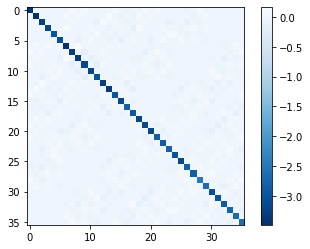

In [ ]:
mol = gto.M(atom="H 0.0 0.0 0.0; H 1.5 0.0 0.0; H 0.0 1.5 0.0; H 0.0, 0.0, 1.5", spin=0, basis="sto-3g")
# "He 0.0 0.0 0.0; H 1.5 0.0 0.0; He 0.0 1.5 0.0; Li 0.0, 0.0, 1.5"
uhf = scf.UHF(mol)
uhf.kernel()

HCI = hci_(uhf)

import matplotlib.pyplot as plt


plt.imshow(HCI, cmap=plt.cm.Blues.reversed(), interpolation='nearest') ## , ,  ## , origin="lower"
plt.colorbar()
plt.savefig("H4_sto3g", dpi=300, transparent=True)
plt.show()

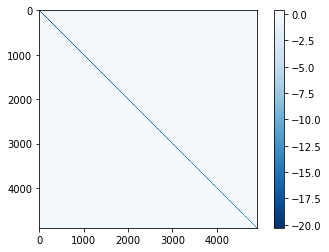

In [ ]:
import matplotlib.pyplot as plt


plt.imshow(H_CI, cmap=plt.cm.Blues.reversed(), interpolation='nearest') ## , ,  ## , origin="lower"
plt.colorbar()
plt.show()

## H$_2$ PES

In [ ]:
mol = gto.M(atom="H 0.0 0.0 0.0; H 0.0 0.0 0.50", spin=0, charge=0, basis="cc-pvdz")
uhf = scf.UHF(mol)
uhf.kernel()

nuclear_rep = uhf.energy_nuc()

E, X = fci_(uhf)
print("MySPSP: " + str( E[0] + nuclear_rep ))

converged SCF energy = -1.04880055621269  <S^2> = 5.1070259e-15  2S+1 = 1
MySPSP: -1.0793700508785389


In [ ]:
from scipy.sparse.linalg import eigsh

mol = gto.M(atom="H 0.0 0.0 0.0; H 0.0 0.0 0.45", spin=0, charge=0, basis="cc-pvdz")
uhf = scf.UHF(mol)
uhf.kernel()

D_sαβ = uhf.make_rdm1()

Binary, SC1, SC2, E, X = fci_sp(uhf, SC=True)
z  = np.arange(0.45, 3, 0.05)

dataPES = np.zeros((len(z), 15))
for i in range(len(z)):
    output = "H" + " " + str(0.) + ", " + str(0.) + ", " + str(z[i])
    mol = gto.M(atom="H 0.0 0.0 0.0; " + output, spin=0, charge=0, basis="cc-pvdz")
    uhf = scf.UHF(mol)
    uhf.kernel(D_sαβ)

    D_sαβ = uhf.make_rdm1()

    nuclear_rep = uhf.energy_nuc()
    E, X = fci_(uhf)
    #H1, H2   = get_SO_matrix(uhf)
    #H_CI     = Dress_H_CI_SPARSE(H1, H2, Binary, SC1, SC2)
    #E, Ψ    = eigsh(H_CI, k=10)

    dataPES[i] = E[:15] + nuclear_rep

converged SCF energy = -1.01400498460167  <S^2> = 2.4802382e-13  2S+1 = 1


KeyboardInterrupt: ignored

In [ ]:
!pip install tikzplotlib
import tikzplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.2 MB/s 


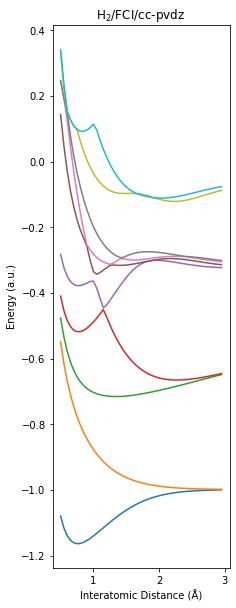

In [ ]:
plt.figure(figsize=(10,10)) 
plt.plot(z, dataPES[:,0])
plt.plot(z, dataPES[:,1])
plt.plot(z, dataPES[:,2])
plt.plot(z, dataPES[:,3])
plt.plot(z, dataPES[:,4])
plt.plot(z, dataPES[:,5])
plt.plot(z, dataPES[:,6])
plt.plot(z, dataPES[:,7])
plt.plot(z, dataPES[:,8])
plt.plot(z, dataPES[:,9])
axes=plt.gca()
axes.set_aspect(5)
plt.ylabel("Energy (a.u.)")
plt.xlabel("Interatomic Distance (Å)")
plt.title("H$_2$/FCI/cc-pvdz")
tikzplotlib.save("H2FCIccpvdz.tex")
plt.show()


In [ ]:
dataPES[:,0]

array([6.2069, 5.5949, 5.0222, 4.4867, 4.0645, 3.7318, 3.4782, 3.2874, 3.1435, 3.0335, 2.9474, 2.8782, 2.821 , 2.7721, 2.729 , 2.69  , 2.6537, 2.6194, 2.5864, 2.5544, 2.5233, 2.4932, 2.464 , 2.4361,
       2.4096, 2.3847, 2.3619, 2.3413, 2.3399, 2.3398, 2.3208, 2.3144, 2.3189, 2.3235, 2.328 , 2.3325, 2.337 , 2.3412, 2.3454, 2.3494, 2.3533, 2.3571, 2.3607, 2.3642, 2.3676, 2.3709, 2.3741, 2.3772,
       2.3799, 2.3822])

# H$^+_3$ Conical Intersection

In [ ]:
from scipy.sparse.linalg import eigsh

mol = gto.M(atom="H 0.0 0.522 0.0; H 0.0 -0.522 0.0; H 0., 0., 0.904", spin=0, charge=1, basis="cc-pvdz")
uhf = scf.UHF(mol)
uhf.kernel()

Binary, SC1, SC2, E, X = fci_sp(uhf, SC=True)

z  = np.arange(-0.1, 0.1, 0.02)
yz = np.asarray(np.meshgrid(z,z))

data = np.zeros((yz.shape[1], yz.shape[2], 10))
for yy in range((yz.shape[1])):
    for zz in range((yz.shape[1])):
          coor_inter = yz[:,yy, zz]
          output = "H" + " " + str(0.) + ", " + str(coor_inter[0]) + ", " + str(coor_inter[1])

          mol = gto.M(atom="H 0.0 0.522 0.0; H 0.0 -0.522 0.0;" + output, spin=0, charge=1, basis="cc-pvdz")
          uhf = scf.UHF(mol)
          uhf.kernel()

          H1, H2   = get_SO_matrix(uhf)
          H_CI     = Dress_H_CI_SPARSE(H1, H2, Binary, SC1, SC2)
          E, Ψ    = eigsh(H_CI, k=10)

          #E, X = fci_sp(uhf)

          data[yy, zz] = E[:10]

          print(yy, zz)


converged SCF energy = -1.27774793716054  <S^2> = 4.485301e-14  2S+1 = 1
converged SCF energy = -0.9482185656439  <S^2> = 5.6865623e-13  2S+1 = 1
0 0
converged SCF energy = -1.01794714637615  <S^2> = 8.8351548e-13  2S+1 = 1
0 1
converged SCF energy = -1.07599242184981  <S^2> = 1.1304291e-12  2S+1 = 1
0 2
converged SCF energy = -1.12079160063765  <S^2> = 1.2270185e-12  2S+1 = 1
0 3
converged SCF energy = -1.15223982010838  <S^2> = 1.2372325e-12  2S+1 = 1
0 4
converged SCF energy = -1.17079048364725  <S^2> = 1.7292834e-12  2S+1 = 1
0 5
converged SCF energy = -1.17691136919485  <S^2> = 1.4654944e-14  2S+1 = 1
0 6
converged SCF energy = -1.17079048364725  <S^2> = 1.7297275e-12  2S+1 = 1
0 7
converged SCF energy = -1.15223982010838  <S^2> = 1.2390089e-12  2S+1 = 1
0 8
converged SCF energy = -1.12079160063766  <S^2> = 1.2279067e-12  2S+1 = 1
0 9
converged SCF energy = -1.07599242184982  <S^2> = 1.130207e-12  2S+1 = 1
0 10
converged SCF energy = -1.01794714637615  <S^2> = 8.8018481e-13  2S+1 

In [ ]:
data.shape
#np.save("fcih3p_", data)

(13, 13, 10)

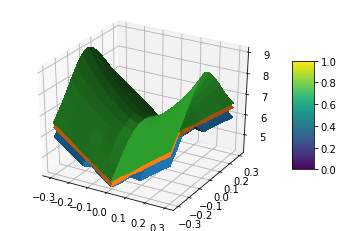

In [ ]:
np.load("fcih3p_.npy").shape
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


surf = ax.plot_surface(yz[0], yz[1], data[:,:,0], linewidth=0, antialiased=False)
surf = ax.plot_surface(yz[0], yz[1], data[:,:,1], linewidth=0, antialiased=False)
surf = ax.plot_surface(yz[0], yz[1], data[:,:,5], linewidth=0, antialiased=False)


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
center = np.array([0., 0., 0.904])

print(str(center)[1:-1])

output = "H" + " " + str(center[0]) + ", " + str(center[1]) + ", " + str(center[2])
output

0.    0.    0.904


'H 0.0, 0.0, 0.904'

In [ ]:
uhf.mo_occ

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

$ \int e^x dx \frac{d\Omega}{dt} \nabla \mathcal{E} =  $



```
# This is formatted as code
```



### ⚠ work on

In [ ]:
num_atoms = 4
box_size  = 3 ## Ångströms
Z    = (np.random.rand(num_atoms) + 1).astype(np.int64)
R_ix =  np.random.rand(num_atoms,3) * box_size

import math

def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

out = ""
for i in range(len(Z)):
    out += str(Z[i]) + " " + str(R_ix[i][0]) + " " + str(R_ix[i][1]) + " " + str(R_ix[i][2]) + "; "

if np.sum(Z) % 2 == 0:
    mol = gto.M(atom=out, spin=0, basis="6-31g") #basis="sto-3g")
    uhf = scf.UHF(mol)
    uhf.kernel()

else:
    mol = gto.M(atom=out, spin=1, basis="6-31g")
    uhf = scf.UHF(mol)
    uhf.kernel()

O_sp   = np.asarray((uhf).mo_occ, dtype=np.int8)
N_s    = np.einsum("sp -> s", O_sp)
numCI  = ( nCr(O_sp.shape[1], N_s[0]) * nCr(O_sp.shape[1], N_s[1]) )

if uhf.converged and numCI < 2000:
    print(numCI)

    cisolver = fci.FCI(uhf)
    pyscf_fci_energy = cisolver.kernel()[0]
    print('PySCF: %.15f' % pyscf_fci_energy)

    E, Ψ = fci_(uhf)
    print("Mine : " + str( E[0] + uhf.energy_nuc() ))

    ## compute my solution!!  def fullci_inpyscf(mf): return E, X


converged SCF energy = -1.97347935236229  <S^2> = 8.2931439e-11  2S+1 = 1
784.0
PySCF: -2.063153259452695
Mine : -2.065563171992842


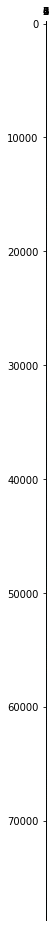

In [ ]:
plt.matshow(a)
plt.show()

In [ ]:
import pyscf
mol = gto.M(atom='H 0.0 0.0 0.0; H 1.5 0.0 0.0', spin=0, basis="aug-cc-pvtz")
uhf = scf.UHF(mol)
uhf.kernel()

cisolver = fci.FCI(uhf)
print('E(UHF-FCI) = %.12f' % cisolver.kernel()[0])

converged SCF energy = -1.00465133202327  <S^2> = 3.2858161e-12  2S+1 = 1
E(UHF-FCI) = -1.067193764576


# Sparse Matrix

In [ ]:
import scipy
import numpy as np 
import pickle

I = np.eye(10000)  #Had 10000 nonzero values along diagonal
S = scipy.sparse.csr_matrix(I)

In [ ]:

mol = gto.M(atom='H 0.0 0.0 0.0; H 1.5 0.0 0.0; H 1.0 0.0 0.0; H 1.5 0.0 1.0', spin=0, basis="sto-3g") ##aug-cc-pvtz
umf = scf.UHF(mol)
umf.kernel()


Binaryy  = get_fci_combos(umf)
#H1, H2   = get_SO_matrix(umf)
dipole   = (umf.mol).intor("int1e_r")
E_t      = np.array([1., 0., 0.])

Ca, Cb = (umf).mo_coeff
dipole_MO = np.asarray([np.einsum("xAB, Ap, Bq -> xpq", dipole, Ca, Ca), np.einsum("xAB, Ap, Bq -> xpq", dipole, Cb, Cb)])

SC1, SC2 = SlaterCondon(Binaryy)

H_CI     = CI_H(H1, H2, Binary, SC1, SC2)

H1, H2   = get_SO_matrix(umf)

converged SCF energy = -1.74490671773148  <S^2> = 1.5266011e-11  2S+1 = 1


ValueError: ignored

In [ ]:
!git clone https://github.com/jcandane/Lightfield

from Lightfield.lightfield import lightfield
import matplotlib.pyplot as plt

field3 = lightfield()
field3.E0 = -1e-2
field3.w  = 50.0
field3.Γ  = 1.0
field3.dt = 0.002
field3.T  = 100
field3.k  = np.array([0.,0.,1.])
E_t, E_w = field3.get_E()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.subplots_adjust(hspace=0.01, wspace=0.25, right=2)

ax1.plot(field3.t, E_t )
ax1.set_xlim(0, 1)
ax1.set_title("Real-Time E-Field, E[0] = " + str(np.linalg.norm(E_t[0])) + " a.u." )
ax1.set(xlabel='time (a.u.)', ylabel='E-field (a.u.)')

ax2.plot(field3.ω, E_w)
ax2.set_title("Frequency E-Field")
ax2.set(xlabel='Frequency (a.u.)', ylabel='E-field')

fig.show()

E_t

In [ ]:
field3.dt

In [ ]:
def Expm(A):
    Eigenvalues, Eigenvectors = np.linalg.eig( A )
    return Eigenvectors @  np.diag(  np.exp( Eigenvalues)  )  @ np.linalg.inv(Eigenvectors)

X   = X[0]
X_t = X[0].conj()

H0 = H_CI

dt = field3.dt

for time in range(len(E_t)):
    H_int = np.einsum("x, sxpq -> spq", E_t[time], dipole_MO)
    U     = Expm( -1j* (H_CI + CI_H1(H_int, SC1)) * dt )
    X     = U @ X
    X_t   = X_t @ (U.conj().T)

In [ ]:
dipole.shape